### Convolution in Action


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import datetime
import torch.optim as optim
from torchvision import datasets, transforms


torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
data_path = '../orig_data/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [5]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [6]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [7]:
conv = nn.Conv2d(3, 16, kernel_size=3) #3 input channels, arbitrary output channels = 16
# weight tensor = 16 output channels x 3 input channs x (3x3) kernel
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [8]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [8]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape


NameError: name 'conv' is not defined

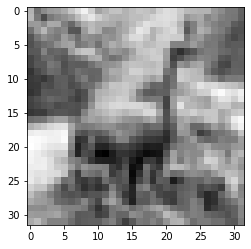

In [10]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

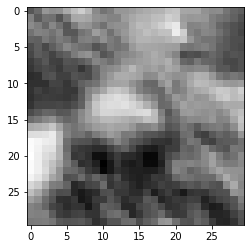

In [11]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Pad the input to maintain size

In [12]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape


(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

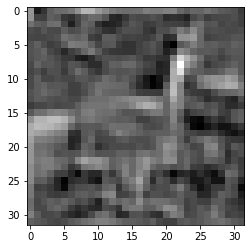

In [13]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Downsampling:
* Average neighbors
* Maximum of neighbors
* Strided convolution where only every Nth pixel is calculated

<img src="../resources/max_pooling.jpg" alt="max_pooling" height="200">

In [15]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape


(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Conv -> MaxPool
<img src="../resources/conv_max.jpg" alt="conv_max" height="200">

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),# 16 channel 32x32 image
    nn.Tanh(),
    nn.MaxPool2d(2), # 16 channel 16x16 image
    nn.Conv2d(16, 8, kernel_size=3, padding=1),  # 16 channel 8x8 image
    nn.Tanh(),
    nn.MaxPool2d(2), # 8 channel 8x8 image
    ### <--- we need to convert 8c 8x8 to 512 dimensional 1D vector
    nn.Linear(8*8*8, 32). # channel 8x8 image -> 1d vector -> 32 outputs
    nn.Tanh(),
    nn.Linearn(32, 2)
)


### Subclassing nn.Module

In [32]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)# 16 channel 32x32 image
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2) # 16 channel 16x16 image
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)  # 16 channel 8x8 image
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2) # 8 channel 8x8 image
        ### <--- we need to convert 8c 8x8 to 512 dimensional 1D vector
        self.fc1 = nn.Linear(8*8*8, 32) # channel 8x8 image -> 1d vector -> 32 outputs
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8*8*8) # reshape for the fully connected
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [33]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### The functional API

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [10]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
model(img.unsqueeze(0))

tensor([[ 0.0746, -0.0411]], grad_fn=<AddmmBackward>)

In [11]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # sum the losses over the epoch
            # we need to transform them into a number with .item()
            # to escape the gradients
            loss_train += loss.item()
        if epoch == 1 or epoch%10==0:
            print('{}, Epoch {}, training loss: {:.4f}'.format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)
            ))

In [12]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2021-03-07 13:39:20.754073, Epoch 1, training loss: 0.5687
2021-03-07 13:39:29.432797, Epoch 10, training loss: 0.3355
2021-03-07 13:39:39.414890, Epoch 20, training loss: 0.2978
2021-03-07 13:39:49.020556, Epoch 30, training loss: 0.2717
2021-03-07 13:39:59.049908, Epoch 40, training loss: 0.2506
2021-03-07 13:40:08.673591, Epoch 50, training loss: 0.2321
2021-03-07 13:40:18.270926, Epoch 60, training loss: 0.2134
2021-03-07 13:40:28.089738, Epoch 70, training loss: 0.1958
2021-03-07 13:40:37.540389, Epoch 80, training loss: 0.1801
2021-03-07 13:40:47.187777, Epoch 90, training loss: 0.1655
2021-03-07 13:40:56.882032, Epoch 100, training loss: 0.1532


In [13]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)


def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            batch_idx = 0
            for imgs, labels in loader:
                print('Batch {}/{}'.format(batch_idx+1, len(loader.dataset)))
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # index of highest output
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)


Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 1/10000
Batch 

### Saving And Loading

In [15]:
device = (torch.device('cuda') if torch.cuda.is_available()else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [20]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device) # move to training device
            labels = labels.to(device=device) # move to training device
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # sum the losses over the epoch
            # we need to transform them into a number with .item()
            # to escape the gradients
            loss_train += loss.item()
        if epoch == 1 or epoch%10==0:
            print('{}, Epoch {}, training loss: {:.4f}'.format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)
            ))

In [21]:
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            batch_idx = 0
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # index of highest output
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [22]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2021-03-07 13:42:35.366603, Epoch 1, training loss: 0.5849
2021-03-07 13:42:38.285658, Epoch 10, training loss: 0.3386
2021-03-07 13:42:41.477880, Epoch 20, training loss: 0.2959
2021-03-07 13:42:44.773300, Epoch 30, training loss: 0.2660
2021-03-07 13:42:47.901390, Epoch 40, training loss: 0.2479
2021-03-07 13:42:50.998146, Epoch 50, training loss: 0.2321
2021-03-07 13:42:54.032933, Epoch 60, training loss: 0.2134
2021-03-07 13:42:57.004925, Epoch 70, training loss: 0.1977
2021-03-07 13:43:00.048431, Epoch 80, training loss: 0.1818
2021-03-07 13:43:03.143679, Epoch 90, training loss: 0.1664
2021-03-07 13:43:06.220574, Epoch 100, training loss: 0.1523


### Loading from device

There is a slight complication when loading network weights: PyTorch will attempt
to load the weight to the same device it was saved from—that is, weights on the GPU
will be restored to the GPU. As we don’t know whether we want the same device, we have two options:
we could move the network to the CPU before saving it, or move it back after restoring.
It is a bit more concise to instruct PyTorch to override the device information when loading weights.
This is done by passing the map_location keyword argument to torch.load

In [24]:
loaded_net = Net().to(device=device)
loaded_net.load_state_dict(torch.load(data_path+ 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

#### Adding memory capacity: Width

Increase the number of output channels of the first conv layer and increase the subsequent
layers accordingly to increase the number of neurons per layer.

The input vector to the fully connected layers is now longer

In [25]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [26]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2021-03-07 13:49:08.198537, Epoch 1, training loss: 0.5813
2021-03-07 13:49:11.555307, Epoch 10, training loss: 0.3130
2021-03-07 13:49:15.633943, Epoch 20, training loss: 0.2680
2021-03-07 13:49:19.245098, Epoch 30, training loss: 0.2341
2021-03-07 13:49:22.875753, Epoch 40, training loss: 0.2088
2021-03-07 13:49:26.462401, Epoch 50, training loss: 0.1834
2021-03-07 13:49:30.445728, Epoch 60, training loss: 0.1611
2021-03-07 13:49:34.146667, Epoch 70, training loss: 0.1421
2021-03-07 13:49:37.811810, Epoch 80, training loss: 0.1204
2021-03-07 13:49:41.672031, Epoch 90, training loss: 0.1028
2021-03-07 13:49:45.650649, Epoch 100, training loss: 0.0861
Accuracy train: 0.96
Accuracy val: 0.88


Avoid hardcoding

In [34]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1=n_chans1
        self.conv1 = nn.Conv2d(3, self.n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.n_chans1, self.n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(self.n_chans1 // 2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, self.n_chans1 // 2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [35]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-03-07 13:55:29.952036, Epoch 1, training loss: 0.5487
2021-03-07 13:55:33.308334, Epoch 10, training loss: 0.3168
2021-03-07 13:55:37.196466, Epoch 20, training loss: 0.2704
2021-03-07 13:55:41.084795, Epoch 30, training loss: 0.2387
2021-03-07 13:55:45.007794, Epoch 40, training loss: 0.2104
2021-03-07 13:55:48.908261, Epoch 50, training loss: 0.1874
2021-03-07 13:55:52.792369, Epoch 60, training loss: 0.1613
2021-03-07 13:55:56.631365, Epoch 70, training loss: 0.1410
2021-03-07 13:56:00.340169, Epoch 80, training loss: 0.1204
2021-03-07 13:56:04.082919, Epoch 90, training loss: 0.1008
2021-03-07 13:56:07.989878, Epoch 100, training loss: 0.0848
Accuracy train: 0.97
Accuracy val: 0.89


NameError: name 'all_acc_dict' is not defined

In [36]:
width_acc = validate(model, train_loader, val_loader)


Accuracy train: 0.97
Accuracy val: 0.89


#### Assisting Convergence and Generalization: Regularization

Keep weigts small by regularizing loss

In [42]:
def training_l2_reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


In [43]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_l2_reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
l2_reg_acc = validate(model, train_loader, val_loader)


2021-03-07 14:04:24.024999 Epoch 1, Training loss 0.5967912924517492
2021-03-07 14:04:28.280230 Epoch 10, Training loss 0.35454992636753496
2021-03-07 14:04:33.070121 Epoch 20, Training loss 0.31809191272896564
2021-03-07 14:04:37.894564 Epoch 30, Training loss 0.3005345251150192
2021-03-07 14:04:42.764859 Epoch 40, Training loss 0.2836620528606852
2021-03-07 14:04:47.456098 Epoch 50, Training loss 0.2679176411241483
2021-03-07 14:04:52.143992 Epoch 60, Training loss 0.254248198857353
2021-03-07 14:04:56.938559 Epoch 70, Training loss 0.24001503175800773
2021-03-07 14:05:01.822721 Epoch 80, Training loss 0.23103937478202163
2021-03-07 14:05:06.626075 Epoch 90, Training loss 0.22021847735544678
2021-03-07 14:05:11.434333 Epoch 100, Training loss 0.21507341324523754
Accuracy train: 0.91
Accuracy val: 0.88


#### Avoid relying on specific features: Dropout

Randomly drop a percentage of features

Dropout is normally active during training, while during the evaluation of a trained model
in production, dropout is bypassed or, equivalently, assigned a probability  equal  to  zero.
This  is  controlled  through  the  train  property  of  the  Dropoutmodule.
Recall that PyTorch lets us switch between the two modalities by calling ```model.train()```

In [45]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [46]:
model = NetDropout().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_l2_reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
dropout_acc = validate(model, train_loader, val_loader)


2021-03-07 14:06:06.639198 Epoch 1, Training loss 0.6012234627061589
2021-03-07 14:06:11.629613 Epoch 10, Training loss 0.4152898824518653
2021-03-07 14:06:17.174882 Epoch 20, Training loss 0.37919276297851734
2021-03-07 14:06:22.868144 Epoch 30, Training loss 0.3592615479686458
2021-03-07 14:06:28.423148 Epoch 40, Training loss 0.345863278409478
2021-03-07 14:06:33.676768 Epoch 50, Training loss 0.3318553808957908
2021-03-07 14:06:39.278375 Epoch 60, Training loss 0.3172346600301706
2021-03-07 14:06:44.656007 Epoch 70, Training loss 0.31052531112151543
2021-03-07 14:06:49.996902 Epoch 80, Training loss 0.2987490235620244
2021-03-07 14:06:55.442558 Epoch 90, Training loss 0.2857463319020666
2021-03-07 14:07:00.871634 Epoch 100, Training loss 0.282200960976303
Accuracy train: 0.90
Accuracy val: 0.88


#### Keep Activations in check: Batch Normalization

Rescale  the  inputs  to  the  activations of the network so that minibatches have a
certain desirable distribution. Recalling  the  mechanics  of  learning  and  the
role  of  nonlinear  activation  functions,  this helps avoid the inputs to activation
functions being too far into the saturated portion of the function, thereby killing
gradients and slowing training.

Batch normalization needs to behave differently during training and inference. In fact,
at inference time, we want to avoid having the output for a specific input depend on
the statistics of the other inputs we’re presenting to the model.As such, we need
a way to still normalize, but this time fixing the normalization parameters once and for all.

In [47]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [48]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
batch_norm_acc = validate(model, train_loader, val_loader)


2021-03-07 14:10:34.541267, Epoch 1, training loss: 0.4611
2021-03-07 14:10:38.827288, Epoch 10, training loss: 0.2689
2021-03-07 14:10:43.255299, Epoch 20, training loss: 0.2149
2021-03-07 14:10:47.722341, Epoch 30, training loss: 0.1752
2021-03-07 14:10:52.166492, Epoch 40, training loss: 0.1352
2021-03-07 14:10:56.826976, Epoch 50, training loss: 0.1038
2021-03-07 14:11:01.404597, Epoch 60, training loss: 0.0791
2021-03-07 14:11:06.027523, Epoch 70, training loss: 0.0604
2021-03-07 14:11:10.799376, Epoch 80, training loss: 0.0479
2021-03-07 14:11:15.555004, Epoch 90, training loss: 0.0783
2021-03-07 14:11:20.457271, Epoch 100, training loss: 0.0235
Accuracy train: 1.00
Accuracy val: 0.89


#### Deeper Models

#### Skip Connections
The addition of the input to the outputof a block of layers.

A skip connection, or a sequence of skip connections in a deep network, creates a direct
path from the deeper parameters to the loss. This makes their contribution to the gradient
of the loss more direct, as partial derivatives of the loss with respect to those parameters
have a chance not to be multiplied by a long chain of other operations.

In [50]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans//2, n_channs//2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4*4*self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [51]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

acc_depth = validate(model, train_loader, val_loader)

2021-03-07 14:21:44.423236, Epoch 1, training loss: 0.5420
2021-03-07 14:21:48.207998, Epoch 10, training loss: 0.3139
2021-03-07 14:21:51.956420, Epoch 20, training loss: 0.2708
2021-03-07 14:21:55.866836, Epoch 30, training loss: 0.2446
2021-03-07 14:22:00.088820, Epoch 40, training loss: 0.2184
2021-03-07 14:22:03.945831, Epoch 50, training loss: 0.1929
2021-03-07 14:22:07.799790, Epoch 60, training loss: 0.1673
2021-03-07 14:22:11.612050, Epoch 70, training loss: 0.1483
2021-03-07 14:22:15.200494, Epoch 80, training loss: 0.1289
2021-03-07 14:22:18.786798, Epoch 90, training loss: 0.1089
2021-03-07 14:22:22.547138, Epoch 100, training loss: 0.0915
Accuracy train: 0.97
Accuracy val: 0.90


Adding the skip connection

In [55]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4*4*self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [56]:
model = NetRes().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

acc_depth = validate(model, train_loader, val_loader)

2021-03-07 14:24:42.420106, Epoch 1, training loss: 0.6272
2021-03-07 14:24:46.216318, Epoch 10, training loss: 0.3230
2021-03-07 14:24:50.307285, Epoch 20, training loss: 0.2893
2021-03-07 14:24:54.475468, Epoch 30, training loss: 0.2550
2021-03-07 14:24:58.646141, Epoch 40, training loss: 0.2211
2021-03-07 14:25:02.803910, Epoch 50, training loss: 0.1975
2021-03-07 14:25:06.893813, Epoch 60, training loss: 0.1741
2021-03-07 14:25:10.944850, Epoch 70, training loss: 0.1536
2021-03-07 14:25:15.037150, Epoch 80, training loss: 0.1261
2021-03-07 14:25:19.114513, Epoch 90, training loss: 0.1074
2021-03-07 14:25:23.205997, Epoch 100, training loss: 0.0891
Accuracy train: 0.94
Accuracy val: 0.88


#### Block Composition

<img src="../resources/block_compose.jpg" alt="block_compose" height="200">

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans=32):
        super().__init__()
        self.n_chans = n_chans
        self.conv2d = nn.Conv2d(self.n_chans, self.n_chans, kernel_size=3, padding=1, bias=False)
        self.batchnorm = nn.BatchNorm2d(num_features=self.n_chans)
        # random initialization
        torch.nn.init.kaimin_normal_(self.conv2d.weight, nonlinearity='relu')
        torch.nn.init.constant(self.batchnorm.weight, 0.5)
        torch.nn.init.zeros_(self.batchnorm.bias)

    def forward(self, x):
        out = torch.relu(self.batchnorm(self.conv2d(x)))
        return out + x

class ResNetDeep(nn.Module):
    def __init__(self, n_chans=32, n_blocks=10):
        super().__init__()
        self.n_chans = n_chans
        self.conv1 = nn.Conv2d(3, n_chans, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans)])
        )
        self.fc1 = nn.Linear(8*8*n_chans, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = view(-1, 8*8*n_chans)
        out = fc1(out)
        out = fc2(out)
        return out

In [ ]:
model = ResNetDeep().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

acc_resnet = validate(model, train_loader, val_loader)